# Reaction-diffusion, metamodeling - HyperPINN - diffrax solver

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\Delta u(t,x) + u(t,x)r(1 - \gamma u(t,x)), t\geq 0, x\in \Omega, \Omega=[0, 50]^2\\
\frac{\partial u(t,x)}{\partial n}\Big|_{x\in\partial\Omega}=\nabla u(t,x)\cdot n=0, t\geq0,\text{Neumann condition},\\
u(0,x)=u_0(x),x\in \Omega
\end{cases}
$$

In all that follows,

- $\gamma=1$
- $D$ is a scalar in $[0.05, 1.]$ homogeneous in space and time
- $r$ is a scalar in $[0.05, 0.15]$ homogenous in space and time

**We want to build a metamodel** and thus, learn the solution $u(t, x)$ of the above problem for all $D$ and for all $r$. To do so, we will use an HyperPINN [https://arxiv.org/pdf/2111.01008.pdf]. Such architectures are available in jinns. The results are compared with a resolution using diffrax

**Note that for a more peaked initial condition one would require hard constraint on the PINN or RAR sampling on the initial condition**



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
from jax import random
import jax.numpy as jnp
import equinox as eqx
import time
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Data Generator

In [4]:
n = 2048
nb = 2048 * 4
ni = 2048

dim = 2
xmin = 0
xmax = 50
ymin = 0
ymax = 50
tmin = 0
tmax = 1
method = "uniform"

Tmax = 50
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    dim=dim,
    domain_batch_size=40,
    initial_batch_size=40,
    border_batch_size=40,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

Initial condition

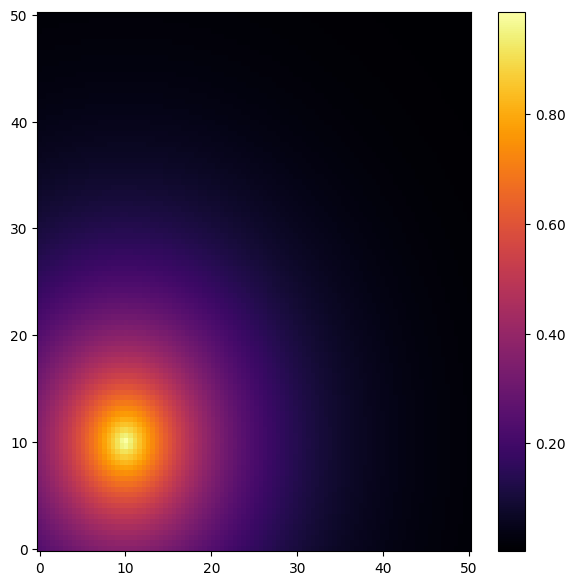

In [5]:
sigma_init = 1 * jnp.ones((2))
mu_init = jnp.array([10.0, 10.0])  # jnp.array([25 / xmax, 25 / ymax])


def u0(x):
    return jnp.exp(-jnp.linalg.norm(x - mu_init) / 10.0)


v_u0 = jax.vmap(u0)

nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx), jnp.linspace(ymin, ymax, ny)]

jinns.plot.plot2d(fun=u0, xy_data=val_xy_data, title="u0(x,y)")

HyperPINN creation. The architecture of the hypernetwork must have inputs equal to the fed hyperparameters (equation parameters) [**must be provided carefully by the user as the `hypernet_input_size` variable**] and outputs equal to the total number of parameters of the PINN network [**automatically fed by jinns internally**]  

In [6]:
eqx_list = (
    (eqx.nn.Linear, 3, 16),
    (jax.nn.swish,),
    (eqx.nn.Linear, 16, 16),
    (jax.nn.swish,),
    (eqx.nn.Linear, 16, 16),
    (jax.nn.swish,),
    (eqx.nn.Linear, 16, 16),
    (jax.nn.swish,),
    (eqx.nn.Linear, 16, 16),
    (jax.nn.swish,),
    (eqx.nn.Linear, 16, 16),
    (jax.nn.swish,),
    (eqx.nn.Linear, 16, 1),
)

eqx_list_hyper = (
    (eqx.nn.Linear, 2, 32),  # input is of size 2 for scalar D and scalar r
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (
        eqx.nn.Linear,
        32,
        1000,
    ),  # 1000 is a random guess, it will automatically be filled with the correct value
)

key, subkey = random.split(key)

hyperparams = ["D", "r"]
hypernet_input_size = 2

dim_x = 2

u, init_nn_params = jinns.nn.HyperPINN.create(
    key=subkey,
    eqx_list=eqx_list,
    eq_type="PDENonStatio",
    hyperparams=hyperparams,
    hypernet_input_size=hypernet_input_size,
    eqx_list_hyper=eqx_list_hyper,
)

Additional batch for the parameters

In [7]:
method = "grid"
key, subkey = random.split(key)
np = 2048
param_batch_size = 40
param_train_data = jinns.data.DataGeneratorParameter(
    key=subkey,
    n=np,
    param_batch_size=param_batch_size,
    param_ranges={"D": (0.05, 1.0), "r": (0.05, 0.15)},
    method=method,
)

### True model parameters and parameter initialization

In [8]:
D = 0.5
g = 1.0
r = 0.1

Note that we feed the parameters obtained from the additional batch into the classical dictionary of parameters

In [9]:
from jinns.parameters import update_eq_params

init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "D": None,
        "r": None,
        "g": jnp.array([g]),
    },
)

init_params = update_eq_params(init_params, param_train_data.get_batch()[1])

The spatial heterogeneity of $r$ is introduced through a user defined function which recreates the spatial map

### Loss construction

In [10]:
from jinns.loss._DynamicLossAbstract import PDENonStatio
from jinns.loss._operators import laplacian_rev


class FisherKPP_reparametrized(PDENonStatio):
    r"""
    Return the Fisher KPP dynamic loss term. Dimension of :math:`x` can be
    arbitrary

    .. math::
        \frac{\partial}{\partial t} u(t,x)=D\Delta u(t,x) + u(t,x)r(x)(1 - \gamma(x)u(t,x))

    """

    def equation(self, t_x, u, params):
        u_ = lambda t_x: u(t_x, params)[0]
        du_dt = jax.grad(u_)(t_x)[0]
        lap = laplacian_rev(t_x, u, params)[..., None]
        return du_dt + self.Tmax * (
            -params.eq_params.D * lap
            - params.eq_params.r
            * u(t_x, params)
            * (1 - params.eq_params.g * u(t_x, params))
        )


fisher_dynamic_loss = FisherKPP_reparametrized(Tmax=Tmax)

In [11]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=1 * Tmax, boundary_loss=1 * Tmax
)

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    boundary_condition=jinns.loss.Neumann(),
    initial_condition_fun=u0,
    params=init_params,
)

In [12]:
from jinns.data import append_param_batch

losses_and_grad = jax.value_and_grad(loss, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    append_param_batch(train_data.get_batch()[1], param_train_data.get_batch()[1]),
)


l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val}' for key, val in d.items()} }")

total loss: 1.1676751375198364
Individual losses: {'dyn_loss': '0.11', 'boundary_loss': '0.00', 'initial_condition': '0.02'}


### Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [13]:
params = init_params

In [14]:
# Optimizer
import optax

tx = optax.adamw(learning_rate=1e-3)

In [15]:
n_iter = 50000

In [16]:
start = time.time()
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=params,
        data=train_data,
        param_data=param_train_data,
        optimizer=tx,
        loss=loss,
        n_iter=n_iter,
    )
)
end = time.time()

Initialization time: 5.096639633178711

Compilation took
 20.960432052612305 

[train] Iteration 0: loss value = 1.0450561046600342
[train] Iteration 1000: loss value = 0.035510893911123276
[train] Iteration 2000: loss value = 0.01576145365834236
[train] Iteration 3000: loss value = 0.0222146138548851
[train] Iteration 4000: loss value = 0.02921018749475479
[train] Iteration 5000: loss value = 0.0099673205986619
[train] Iteration 6000: loss value = 0.04503808915615082
[train] Iteration 7000: loss value = 0.01561015471816063
[train] Iteration 8000: loss value = 0.0077557070180773735
[train] Iteration 9000: loss value = 0.007950755767524242
[train] Iteration 10000: loss value = 0.005169909447431564
[train] Iteration 11000: loss value = 0.015911318361759186
[train] Iteration 12000: loss value = 0.013262158259749413
[train] Iteration 13000: loss value = 0.008212124928832054
[train] Iteration 14000: loss value = 0.002742400858551264
[train] Iteration 15000: loss value = 0.003793449141085148

In [17]:
time_training = end - start
print("Time training the metamodel", time_training)

Time training the metamodel 84.26403570175171


### Save the network and params

In [18]:
from jinns.nn import save_pinn

filename = f"./metamodel-reacdiff-{n_iter}iter"
kwargs_creation = {
    "key": subkey,
    "eqx_list": eqx_list,
    "eq_type": "PDENonStatio",
    "hyperparams": hyperparams,
    "hypernet_input_size": hypernet_input_size,
    "dim_x": 1,
    "eqx_list_hyper": eqx_list_hyper,
}
save_pinn(filename, u, params, kwargs_creation)

### Results

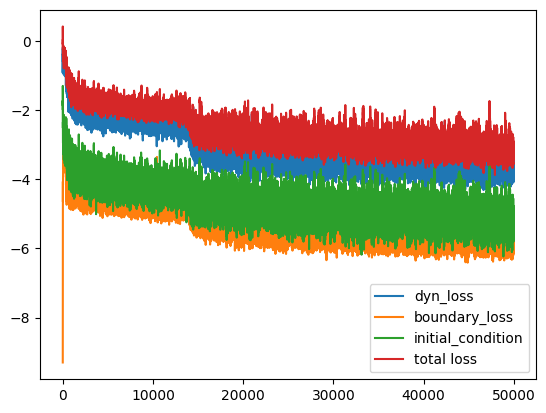

In [19]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

## Plot the PDE solution learned by the PINN for $D=1$ and $r=0.15$

In [20]:
t_ind = jnp.array([0, 1, 10, 25, 48, 50])
times = jnp.round(t_ind * 1.0 / Tmax, decimals=2)
nx, ny = 50, 50
val_xy_data = [jnp.linspace(xmin, xmax, nx), jnp.linspace(ymin, ymax, ny)]

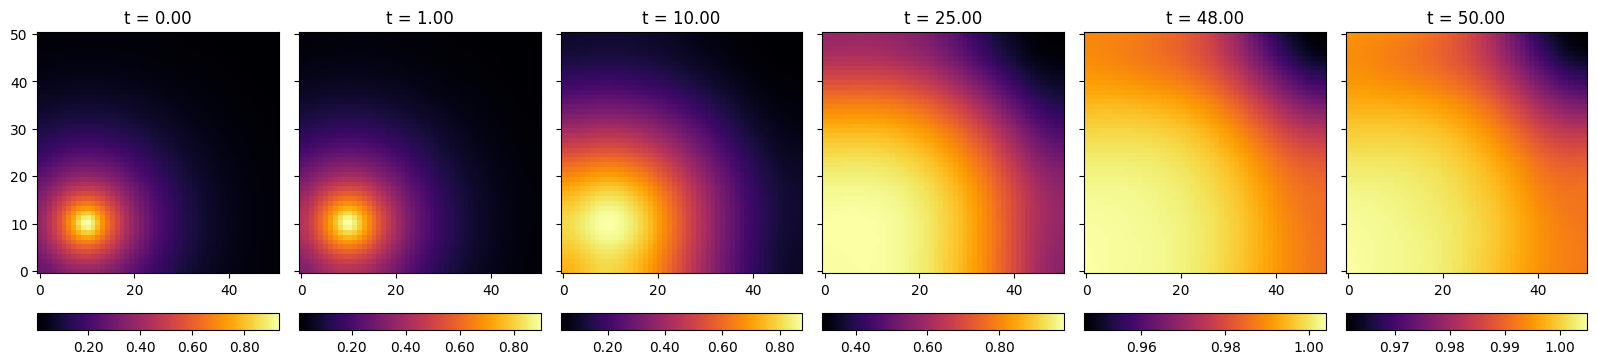

In [21]:
u_est = lambda t_x: u(
    t_x,
    jinns.parameters.Params(
        nn_params=params.nn_params,
        eq_params={"g": g, "D": jnp.array([1.0]), "r": jnp.array([0.15])},
    ),
)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(20, 20 * len(times)),
)

## Compare the results with a PDE solver (Diffrax and finite differences method)

The `jinns.experimental` module contains helper class and functions to solve reaction-diffusion equation with finite differences.

Mostly adapted from [https://docs.kidger.site/diffrax/examples/nonlinear_heat_pde/](https://docs.kidger.site/diffrax/examples/nonlinear_heat_pde/).

In [22]:
from jinns.experimental import (
    SpatialDiscretisation,
    plot_diffrax_solution,
    reaction_diffusion_2d_vector_field,
)
import diffrax

# Spatial discretisation
xmin, xmax = 0, 50
ymin, ymax = 0, 50
nx, ny = 50, 50

y0 = SpatialDiscretisation.discretise_fn(xmin, xmax, ymin, ymax, nx, ny, u0)

# Temporal discretisation
times_save_dfx = jnp.arange(0, Tmax + 1)

# Tolerances for non-stiff problems
rtol = 1e-3
atol = 1e-6
# Tolerances for stiff problems (along with using float64)
# rtol = 1e-7
# atol = 1e-9
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=1
)

solver = diffrax.Dopri5()
max_steps = int(1e6)
saveat = (times_save_dfx,)

xbounds = (xmin, xmax)
ybounds = (ymin, ymax)

dt0 = 0.05
diffeqsolve_kwargs = {
    "t0": 0,
    "t1": int(times_save_dfx.max()),
    "dt0": dt0,
    "y0": y0,
    "saveat": diffrax.SaveAt(ts=times_save_dfx),
    "stepsize_controller": stepsize_controller,
    "max_steps": max_steps,
    "solver": solver,
}

r=0.15,D=1.00


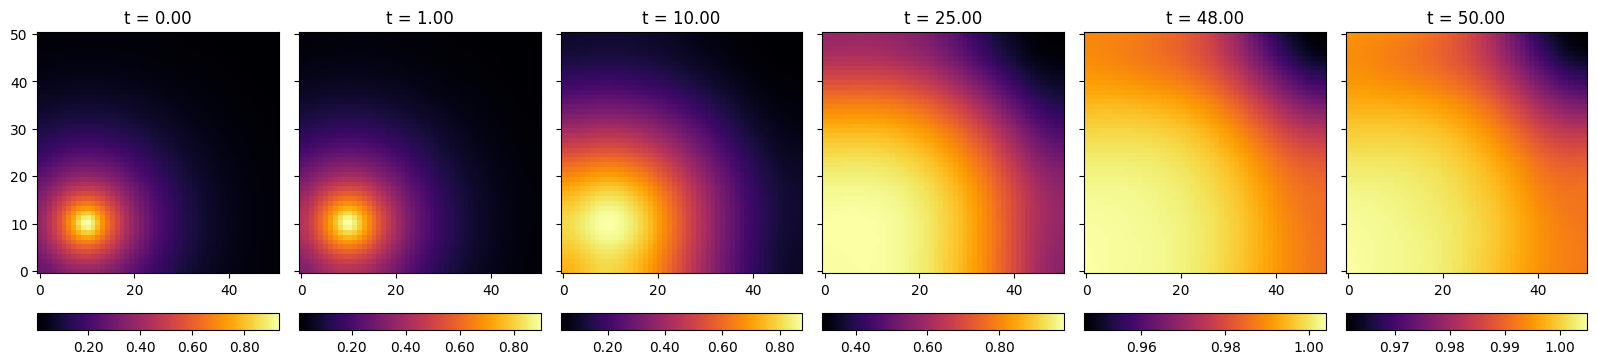

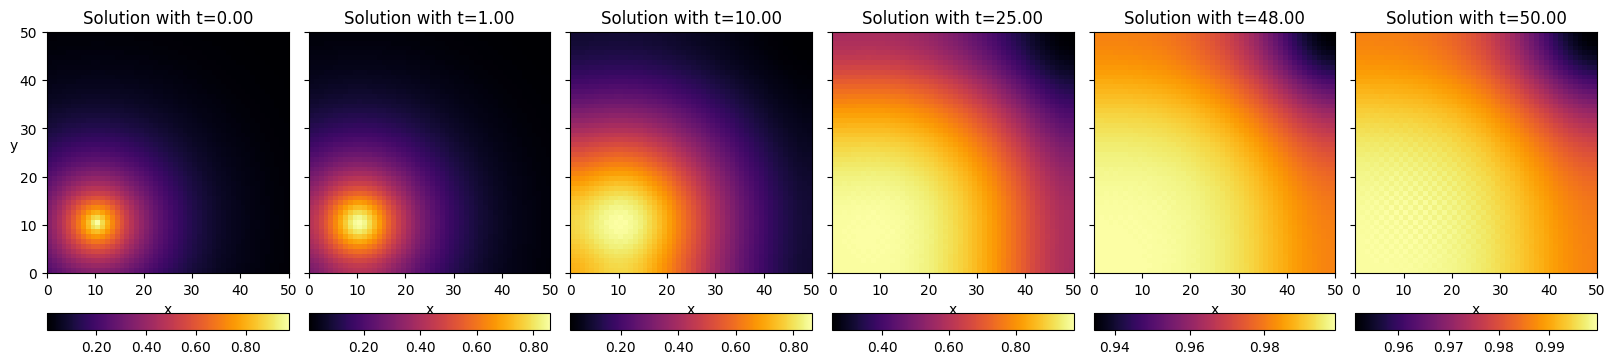

In [23]:
D = jnp.array(1.0)
r = jnp.array(0.15)

diffeqsolve_kwargs["args"] = (
    D,
    r,
)  # This is where we feed the vector field additional parameters

# The following instructions are represent the classical diffrax procedure
term = diffrax.ODETerm(reaction_diffusion_2d_vector_field)
diffrax_solution = diffrax.diffeqsolve(term, **diffeqsolve_kwargs)
print(f"r={float(r):.2f},D={float(D):.2f}")


# Plot
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(20, 20 * len(t_ind)),
)

plot_diffrax_solution(diffrax_solution, xbounds, ybounds, t_ind=t_ind)

## $D=0.1$ and $r=0.1$

r=0.10,D=0.10


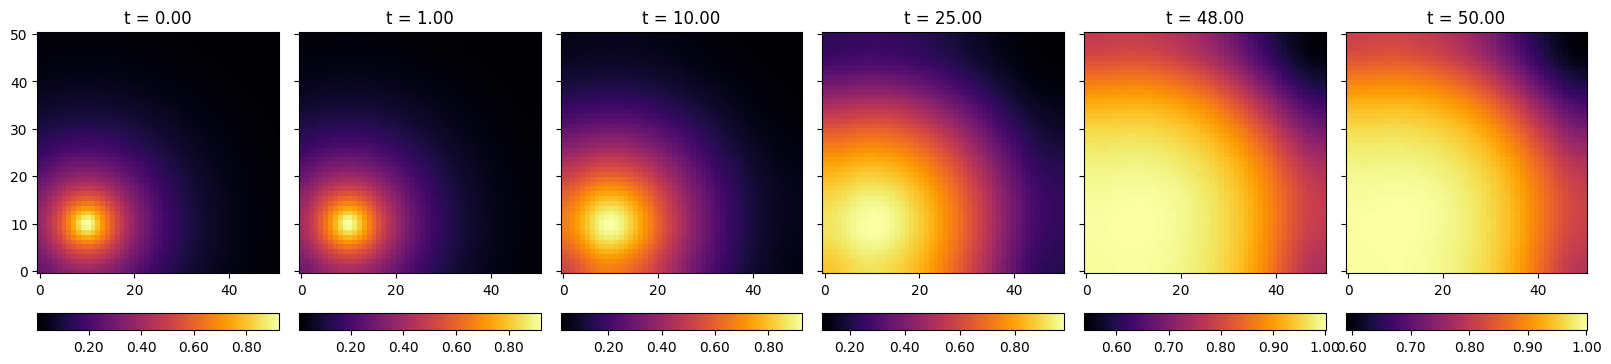

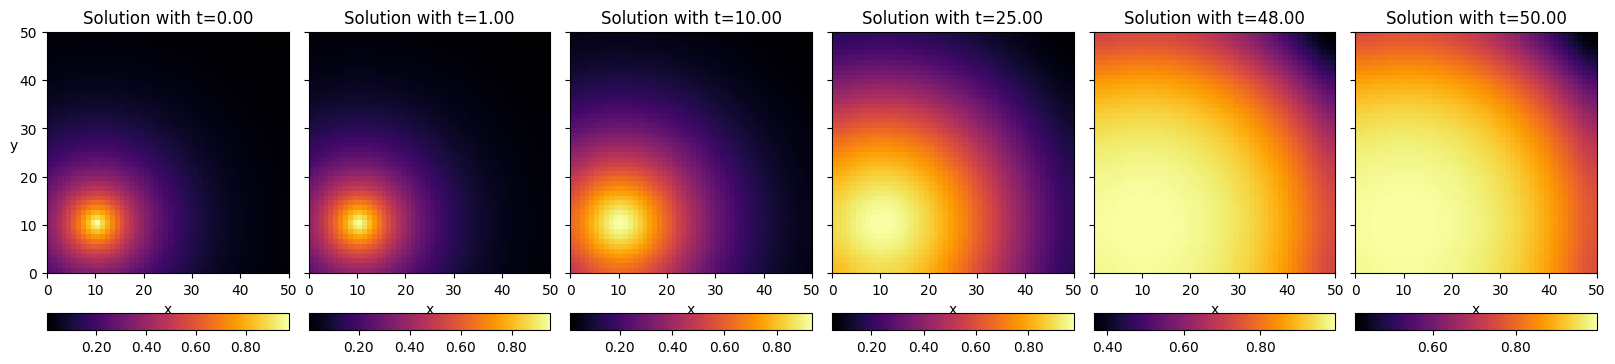

In [24]:
u_est = lambda t_x: u(
    t_x,
    jinns.parameters.Params(
        nn_params=params.nn_params,
        eq_params={"g": g, "D": jnp.array([0.1]), "r": jnp.array([0.1])},
    ),
)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(20, 20 * len(times)),
)

D = jnp.array(0.1)
r = jnp.array(0.1)

diffeqsolve_kwargs["args"] = (D, r)

term = diffrax.ODETerm(reaction_diffusion_2d_vector_field)
diffrax_solution = diffrax.diffeqsolve(term, **diffeqsolve_kwargs)
print(f"r={float(r):.2f},D={float(D):.2f}")
plot_diffrax_solution(diffrax_solution, xbounds, ybounds, t_ind=t_ind)

## $D=0.05$ and $r=0.05$

r=0.05,D=0.05


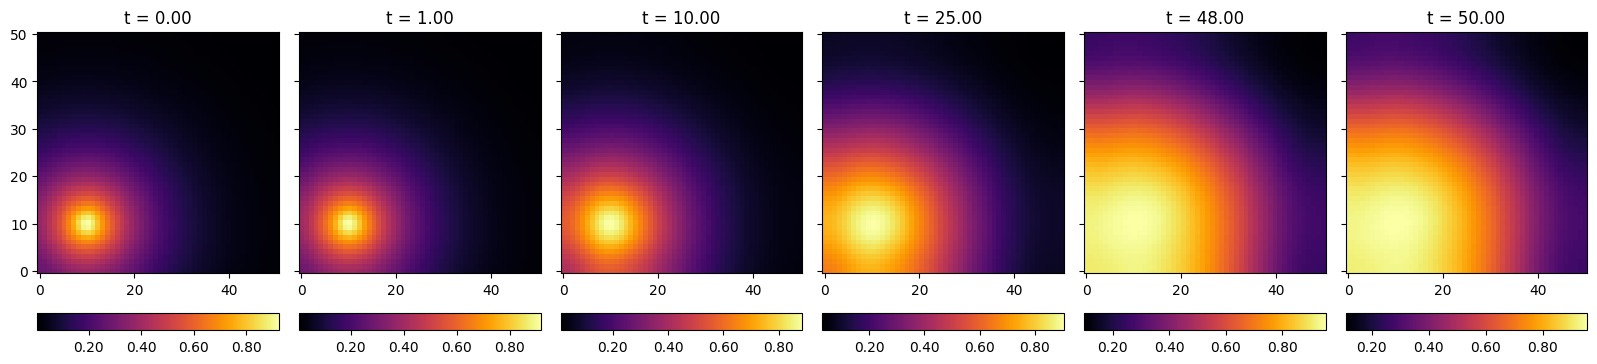

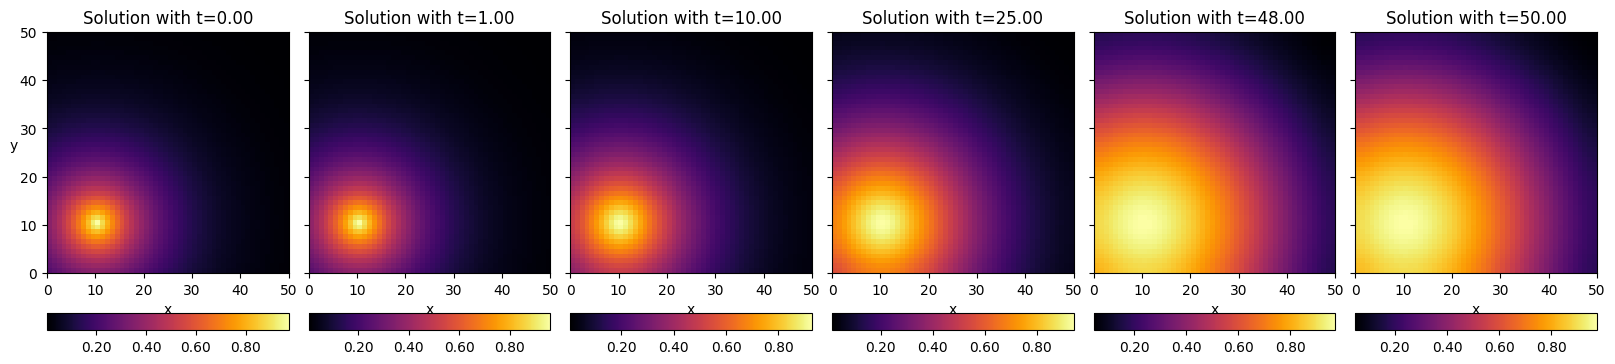

In [25]:
u_est = lambda t_x: u(
    t_x,
    jinns.parameters.Params(
        nn_params=params.nn_params,
        eq_params={"g": g, "D": jnp.array([0.05]), "r": jnp.array([0.05])},
    ),
)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(20, 20 * len(times)),
)

D = jnp.array(0.05)
r = jnp.array(0.05)

diffeqsolve_kwargs["args"] = (D, r)

term = diffrax.ODETerm(reaction_diffusion_2d_vector_field)
diffrax_solution = diffrax.diffeqsolve(term, **diffeqsolve_kwargs)
print(f"r={float(r):.2f},D={float(D):.2f}")
plot_diffrax_solution(diffrax_solution, xbounds, ybounds, t_ind=t_ind)